In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

AUTOTUNE = tf.data.AUTOTUNE

from shared_funcs import multi_label_binary_encode_tensor, multi_label_binary_decode_tensor, get_waveform, split_into_windows, split_into_sequences 

# Load Data

### Helper Functions

In [7]:
ALL_LABELS = tf.constant(['Rctrl', 'p', 'esc', 'g', 'slash', 'down', '7', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'end', 'Rshift', 'comma', 'c', 'tab', 'b', 'j', 'right', 'Lctrl', 'n', 't', 'f', 'm', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'left', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'up', 'u', 'delete'], dtype=tf.string)


# print(multi_label_binary_encode_tensor("no_keypress"))
# print(multi_label_binary_encode_tensor(["no_keypress", "p", "g"]))
# print(multi_label_binary_decode_tensor(multi_label_binary_encode_tensor(["no_keypress"])))
# print(multi_label_binary_decode_tensor(multi_label_binary_encode_tensor(["no_keypress", "p", "g"])))


### MKA Dataset Functions


### Load Datasets

In [8]:
# Load MKA Dataset
mka_path = os.path.dirname(os.getcwd()) + "/data-manipulation/mka_dataset"
mka_dataset = tf.data.Dataset.load(mka_path)

# Load supplementary dataset
supp_path = os.path.dirname(os.getcwd()) + "/data-manipulation/supp_dataset"
supp_dataset = tf.data.Dataset.load(supp_path)

mka_dataset.cache()
supp_dataset.cache()
mka_dataset = mka_dataset.prefetch(tf.data.AUTOTUNE)
supp_dataset = supp_dataset.prefetch(tf.data.AUTOTUNE)

print(mka_dataset.element_spec)
print(supp_dataset.element_spec)


(TensorSpec(shape=(3, 2205), dtype=tf.float32, name=None), TensorSpec(shape=(3, 63), dtype=tf.int32, name=None))
(TensorSpec(shape=(3, 2205), dtype=tf.float32, name=None), TensorSpec(shape=(3, 63), dtype=tf.int32, name=None))


# Data Visualization

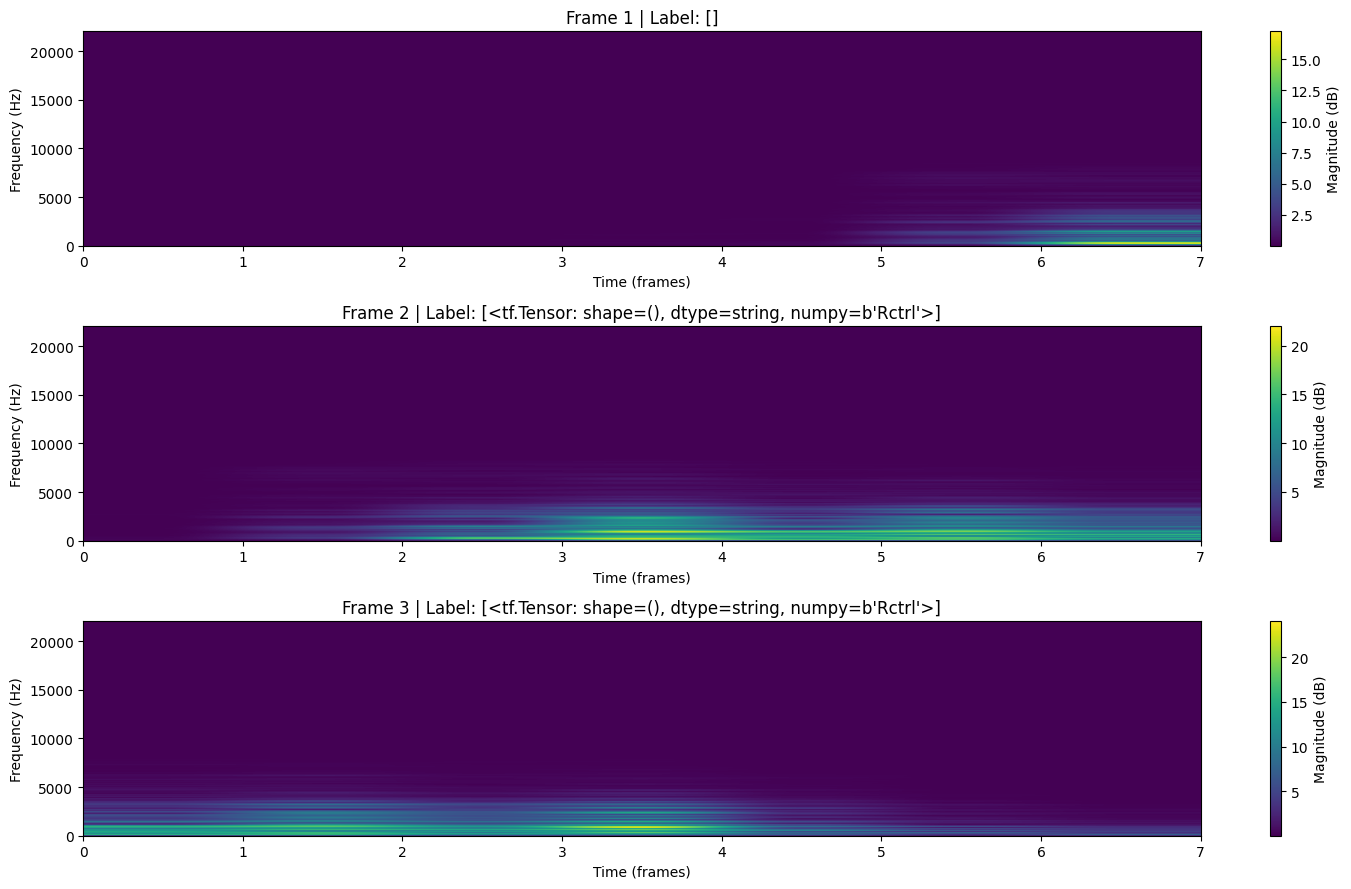

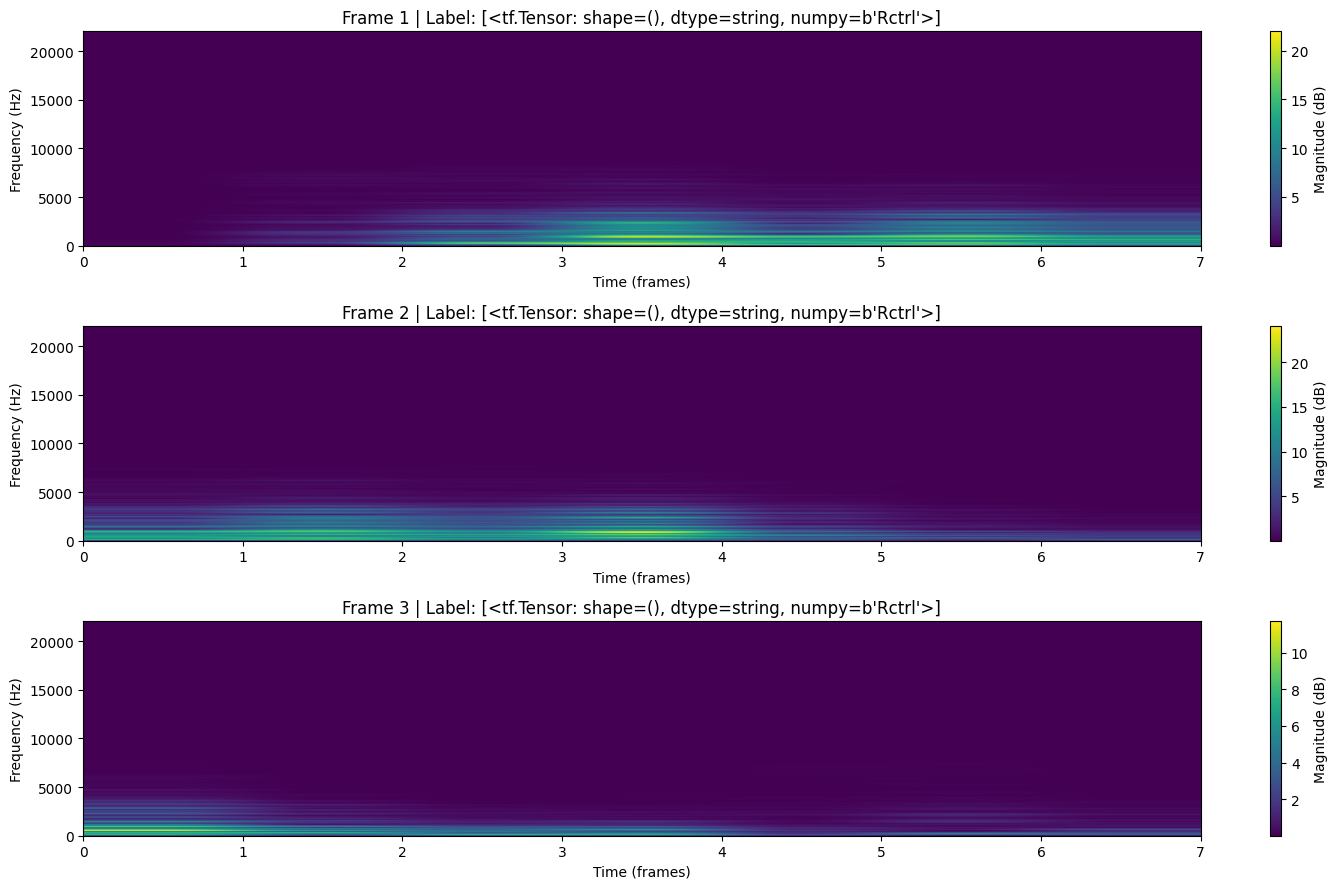

2024-12-02 12:33:12.996235: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


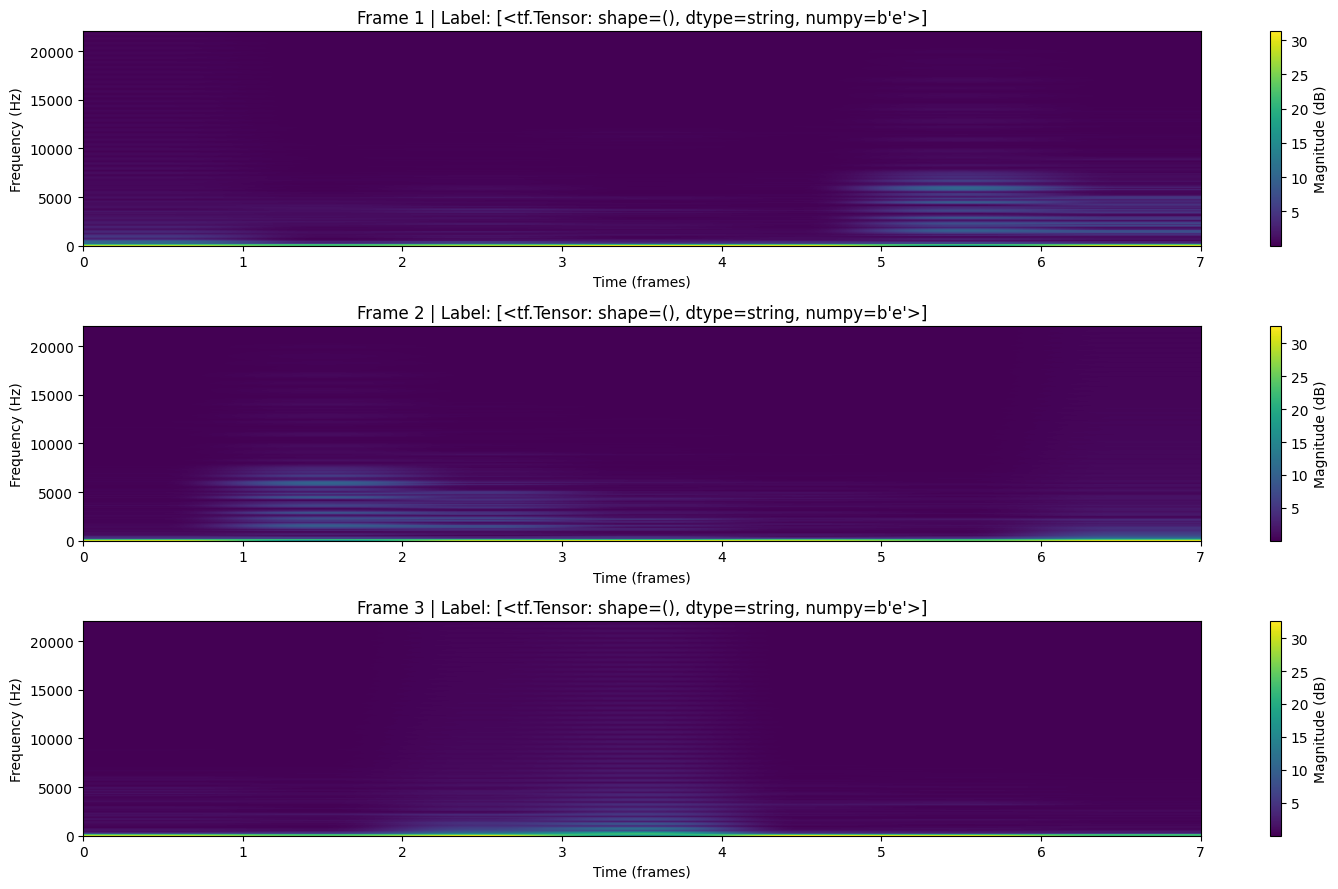

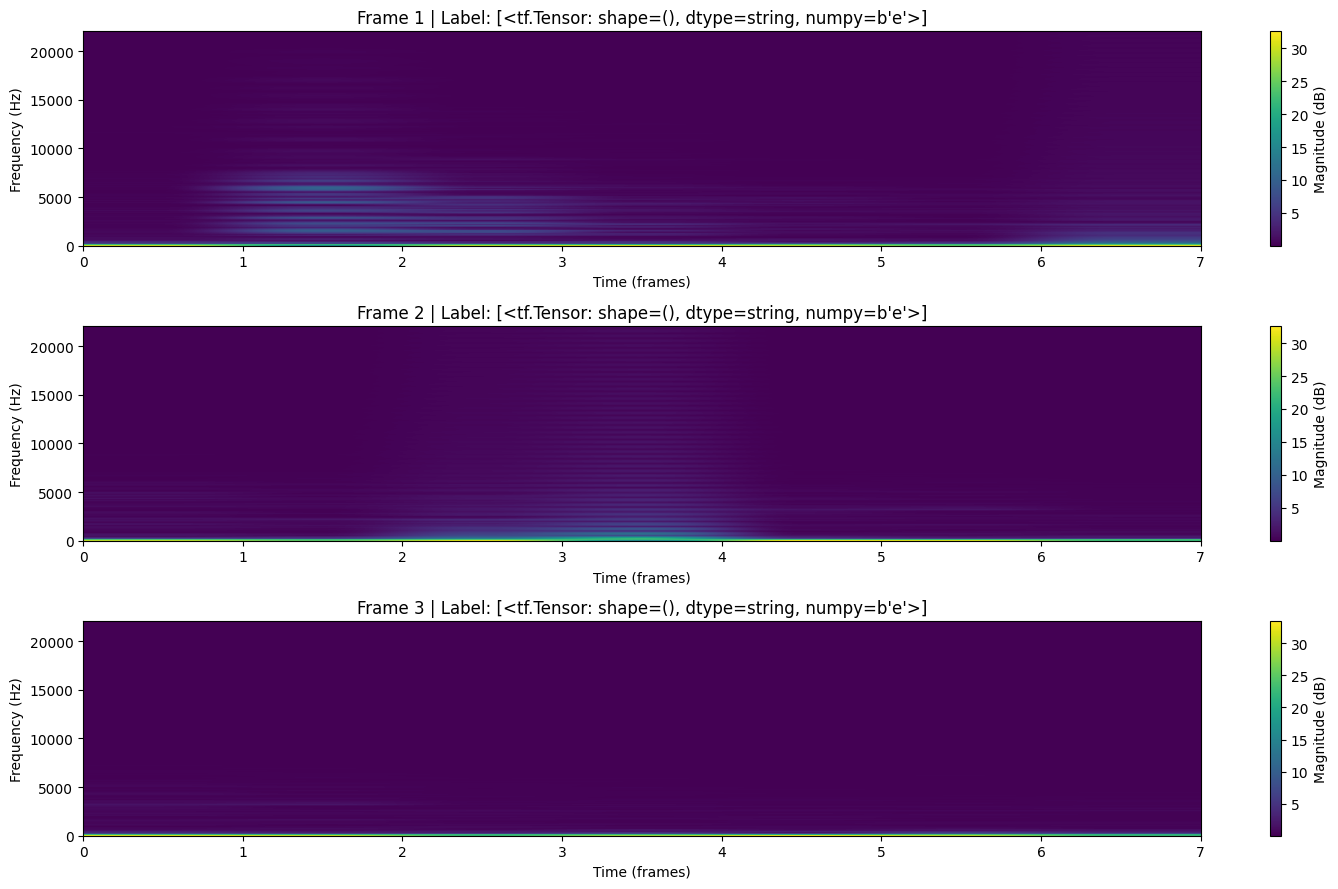

In [9]:
def plot_spectrogram_sequence(sequence, sample_rate=44100, frame_length=2205, frame_step=1102, label=None):
    sequence_length = sequence.shape[0]
    
    plt.figure(figsize=(15, 3 * sequence_length))  # Adjust figure size based on sequence length

    for i, frame in enumerate(sequence):
        # Compute STFT (Short-Time Fourier Transform)
        stft = tf.signal.stft(
            frame,
            frame_length=frame_length // 4,
            frame_step=frame_step // 4,
            fft_length=frame_length // 2,
        )
        
        # Compute magnitude spectrogram
        spectrogram = tf.abs(stft)
        spectrogram = tf.transpose(spectrogram)  # Transpose for better visualization

        # Plot the spectrogram
        plt.subplot(sequence_length, 1, i + 1)
        plt.imshow(
            10 * tf.math.log1p(spectrogram).numpy(),  # Log-scaled spectrogram
            aspect='auto',
            origin='lower',
            extent=[0, spectrogram.shape[1], 0, sample_rate / 2]
        )
        plt.colorbar(label="Magnitude (dB)")
        title = f"Frame {i + 1}"
        if label is not None:
            title += f" | Label: {label[i]}"
        plt.title(title)
        plt.ylabel("Frequency (Hz)")
        plt.xlabel("Time (frames)")

    plt.tight_layout()
    plt.show()

# ds = flattened_ds.shuffle(10000)
for sequence, label_sequence in mka_dataset.take(2):
    plot_spectrogram_sequence(sequence, label=[multi_label_binary_decode_tensor(x) for x in label_sequence])
for sequence, label_sequence in supp_dataset.take(2):
    plot_spectrogram_sequence(sequence, label=[multi_label_binary_decode_tensor(x) for x in label_sequence])



### Merge Datasets

# Spectrogram Generation

Spectrograms shape: (32, 3, 1103)
Labels shape: (32, 3, 63)


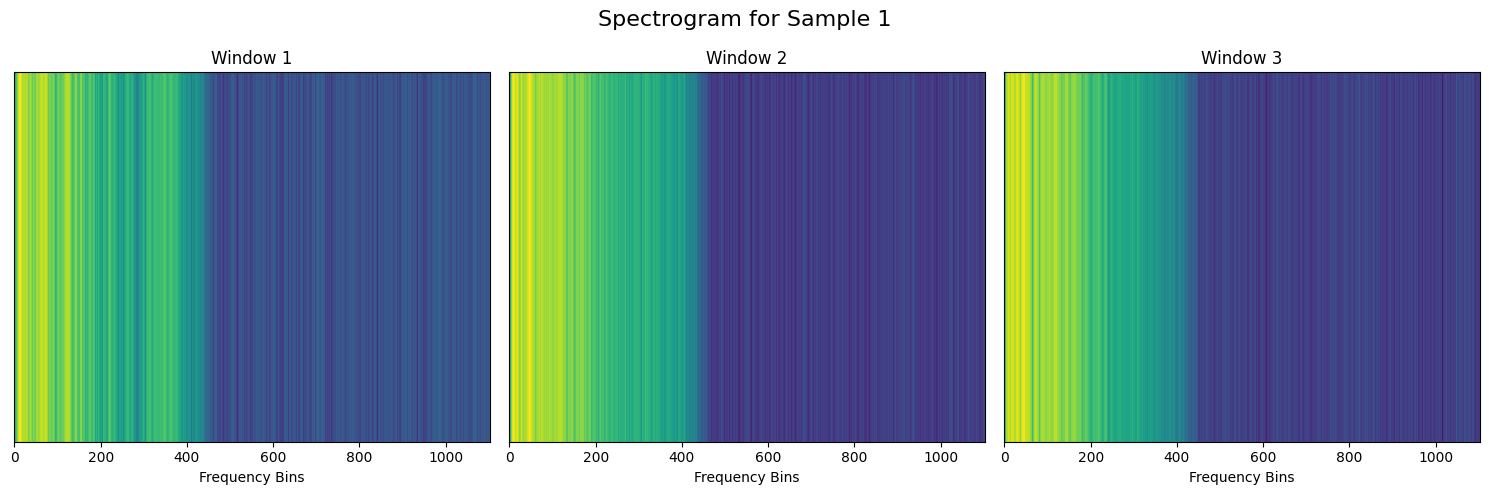

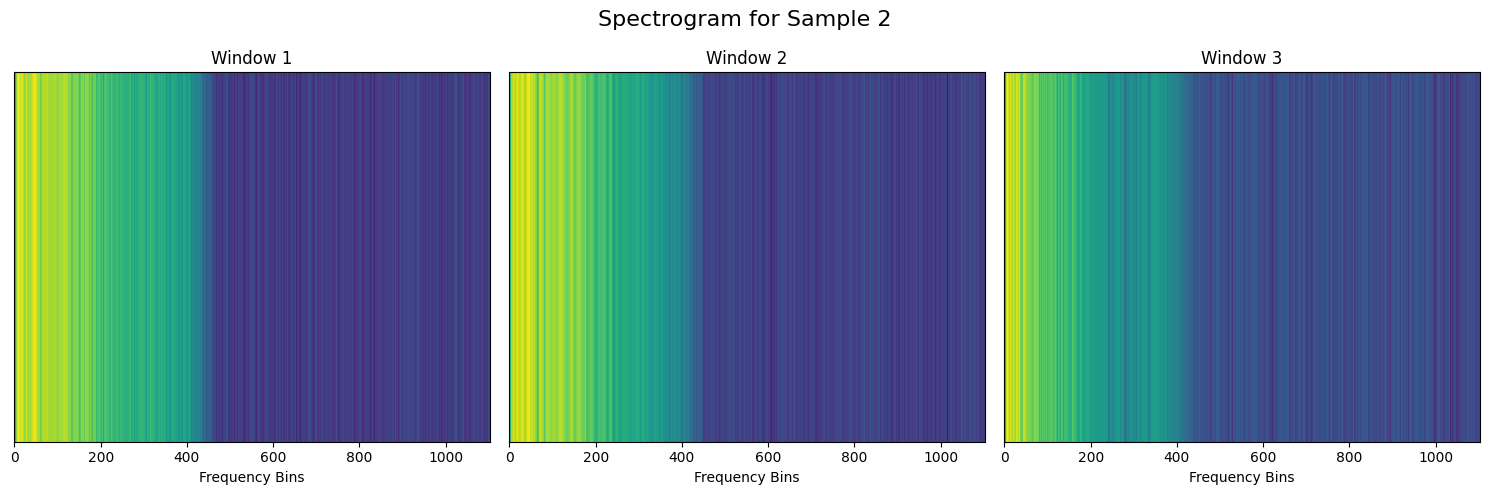

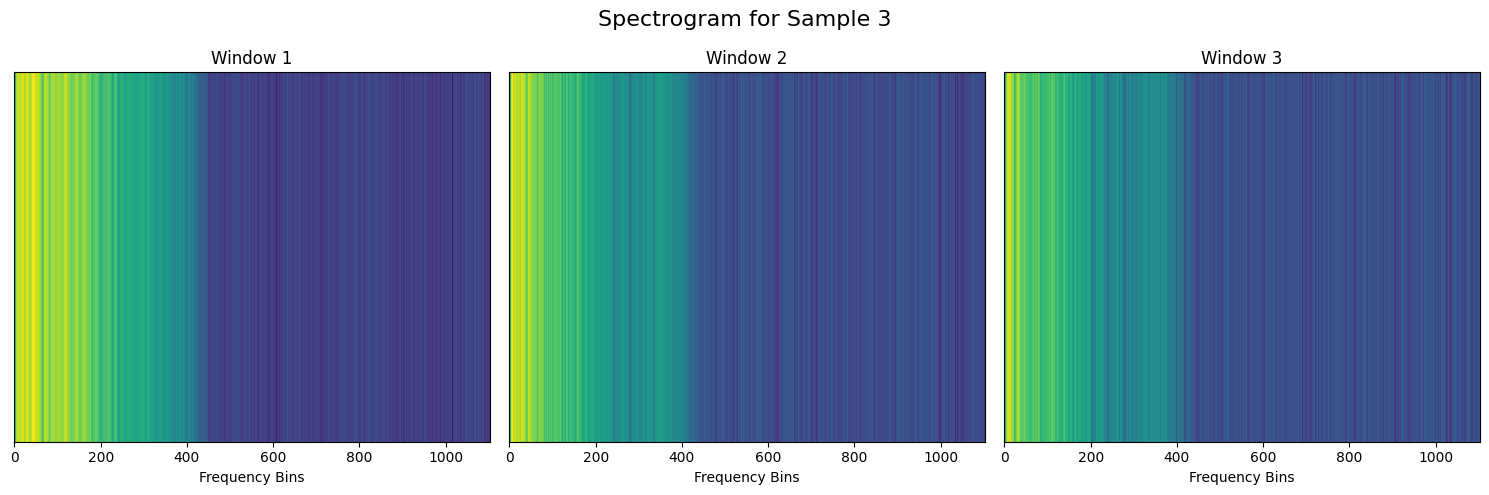

In [ ]:
def compute_window_spectrogram(window, frame_length=2205, frame_step=2205):
    spectrogram = tf.signal.stft(
        window,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length
    )

    # Compute magnitude of STFT (Spectrogram)
    spectrogram_magnitude = tf.abs(spectrogram)

    # Normalize spectrogram
    spectrogram_magnitude = tf.math.log(spectrogram_magnitude + 1e-6)  

    # print("STFT Spectrogram Shape:", spectrogram_magnitude.shape)
    return spectrogram_magnitude

def compute_sequence_spectrograms(windows, labels):
    spectrograms = tf.map_fn(compute_window_spectrogram, windows)
    
    # Remove time dimension from spectrogram since it will be the same size as the initial sliding window I have
    spectrograms = tf.squeeze(spectrograms, axis=2)
    return spectrograms, labels

mka_dataset = mka_dataset.batch(32)

spectrogram_dataset = mka_dataset.map(
    lambda windows, labels: compute_sequence_spectrograms(windows, labels),
    num_parallel_calls=AUTOTUNE
)

spectrogram_dataset = spectrogram_dataset.prefetch(buffer_size=AUTOTUNE)

for spectrograms, labels in spectrogram_dataset.take(1):
    print("Spectrograms shape:", spectrograms.shape)
    print("Labels shape:", labels.shape)


def plot_sequence_spectrograms(spectrogram, title="Sample Spectrograms"):
    """
    Plot spectrograms for a single sample with 3 overlapping windows.

    Args:
        spectrogram: Tensor of shape (3, 1103) for one sample.
        title: Title for the plot.
    """
    spectrogram = spectrogram.numpy()  # Convert TensorFlow tensor to NumPy array

    num_windows = spectrogram.shape[0]  # Number of windows (3 in this case)

    # Create a figure with subplots for each window
    fig, axes = plt.subplots(1, num_windows, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes):
        # Plot each spectrogram
        ax.imshow(
            spectrogram[i].reshape(1, -1),  # Reshape to (1, 1103) to visualize frequency bins as 1 row
            aspect="auto",
            origin="lower",
            cmap="viridis"
        )
        ax.set_title(f"Window {i+1}")
        ax.set_xlabel("Frequency Bins")
        ax.set_yticks([])  # Remove y-axis labels since there's only 1 row
        ax.set_ylabel("")  # Clear y-axis label

    plt.tight_layout()
    plt.show()

# Test plotting on the first batch
for spectrograms, labels in spectrogram_dataset.take(1):  # Take one batch
    for i, spectrogram in enumerate(spectrograms).take(3):  # Iterate through the batch (32 samples)
        plot_sequence_spectrograms(
            spectrogram, title=f"Spectrogram for Sample {i+1}"
        )
        if i == 2:  # Limit to first 3 samples for visualization
            break